In [17]:
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import base64
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [18]:
import pytesseract

In [19]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

In [20]:
driver = webdriver.Firefox()
driver.get("https://logigames.bet9ja.com/games.ls?page=launch&gameid=18000&skin=12&sid=&pff=1&tmp=1611946195")

In [21]:

GAME_CANVAS = "layer2"

In [34]:
def getTemplate(TEMPLATE_NAME):
    return cv2.imread('imgs/templates/{}.png'.format(TEMPLATE_NAME),0)

def getGameImage(driver, el_class_name = None):
    """Returns gray scale Image of the canvas """
    
    c1_element = driver.find_element_by_id(el_class_name)
    canvas = c1_element.screenshot_as_base64
    cap = base64.b64decode(canvas)
    image = cv2.imdecode(np.frombuffer(cap, np.uint8), 1)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image



def detectTemplate(image, template, visualize = False, method_num = -1):
    img2 = image
    w, h = template.shape[::-1]
    # All the 6 methods for comparison in a list
    methods = [['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
                'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'][method_num]]
    # methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
    #             'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
    for meth in methods:
        img = img2.copy()
        method = eval(meth)
        # Apply template Matching
        res = cv2.matchTemplate(img,template,method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        ### Visualize the Detection?
        if(visualize == True):
            cv2.rectangle(img,top_left, bottom_right, 255,20)
            plt.subplot(121),plt.imshow(res,cmap = 'gray')
            plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
            plt.subplot(122),plt.imshow(img,cmap = 'gray')
            plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
            plt.suptitle(meth)
            plt.show()
    return (top_left, bottom_right, res)

def clickScreen(top_left):
    try:
        #myElem = WebDriverWait(driver, delay).until(EC.element_to_be_clickable((By.CLASS_NAME, 'game')))
        game_element = driver.find_element_by_class_name("game")
        myElem = game_element
        action = webdriver.common.action_chains.ActionChains(driver)
        action.move_to_element_with_offset(myElem, top_left[0] + 50, top_left[1] + 50)
        action.click()
        action.perform()
        print("Action Performed!")
    except TimeoutException:
        print("Loading took too much time!")

In [23]:
tmp =  getTemplate("continue")

(54, 198)

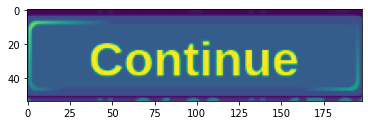

In [24]:
plt.imshow(tmp)
tmp.shape

In [25]:
game_image = getGameImage(driver, GAME_CANVAS)

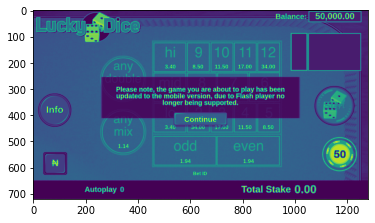

In [26]:
plt.imshow(game_image)

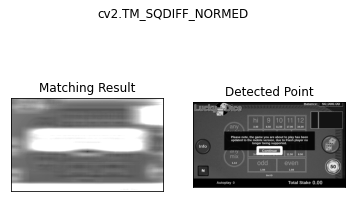

In [27]:
coord  = detectTemplate(game_image, tmp, True)

In [28]:
coord

((541, 387), (739, 441))

In [29]:
clickScreen(coord[0])

Action Performed!


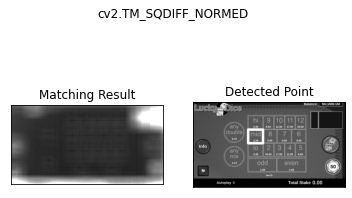

Action Performed!


In [30]:
tmp =  getTemplate("mid")
game_image = getGameImage(driver, GAME_CANVAS)
coord  = detectTemplate(game_image, tmp, True)
clickScreen(coord[0])

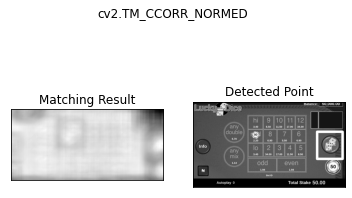

Action Performed!


In [31]:
tmp =  getTemplate("bet")
game_image = getGameImage(driver, GAME_CANVAS)
coord  = detectTemplate(game_image, tmp, True, 3)
clickScreen((coord[0][0] + 100, coord[0][1] + 100) )

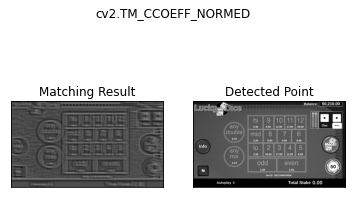

In [103]:
tmp =  getTemplate("Lone")
game_image = getGameImage(driver, GAME_CANVAS)
coord  = detectTemplate(game_image, tmp, True, 1)
#clickScreen((coord[0][0] + 100, coord[0][1] + 100) )

In [104]:
coord

((1175, 191),
 (1235, 220),
 array([[-0.06876961, -0.06806863, -0.06653795, ...,  0.06704012,
          0.02166226, -0.04367033],
        [-0.11623918, -0.11582746, -0.1147959 , ...,  0.02974587,
         -0.02169303, -0.09383791],
        [-0.1312008 , -0.1308992 , -0.13020335, ...,  0.02324672,
         -0.0324901 , -0.10943518],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.1000386 , -0.10004245, -0.10004932, ..., -0.08610511,
         -0.08565401, -0.08528794]], dtype=float32))

In [105]:
res = coord[-1]
loc = np.where( res >= 0.8)

In [106]:
loc

(array([190, 190, 191, 191, 191, 191, 191, 192, 192]),
 array([1072, 1175, 1072, 1073, 1174, 1175, 1176, 1072, 1175]))

In [131]:
loc_tmp = sorted(loc[1])

def extractCoordinates(coordArray):
    cluster1 = []
    cluster2 = []
    loc_tmp = coordArray
    nextc = False
    for i in range(0,len(loc_tmp)-1):
        tmp = abs(loc_tmp[i+1] - loc_tmp[i])
        if((tmp <20) & (nextc ==False)):
            cluster1.append(loc_tmp[i])
        else:
            if(nextc == False):
                cluster1.append(loc_tmp[i])
                nextc = True
            else:
                cluster2.append(loc_tmp[i])
        return (int(np.mean(cluster1)), int(np.mean(cluster2)))

1072

1174

In [107]:
cv2.minMaxLoc(res)

(-0.42395177483558655, 0.999994695186615, (34, 607), (1175, 191))

In [99]:
tmp =  getTemplate("continue")

In [12]:
import cv2
import numpy as np

img = cv2.imread('image.jpg')

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

'a Corey dialecsy\n\x0c'

'a Continue\n\x0c'